In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import copy
from datetime import timedelta

%matplotlib inline

In [2]:
outdir='data/'
dsets = ['_moc_rho2_online_lores.nc', '_moc_rho2_online_mean_lores_reprojected.nc','_sigma2_jmd95_zmean.nc']

ddict = {mod:{} for mod in ['CM4','ESM4']}

for mod in ddict:
    ddict_exp = {exp:{} for exp in ['control','stress','antwater','antwaterstress']}
    for exp in ddict_exp:
        if exp == 'control':
            
            for dset,var in zip(dsets,['psi','psiz','sig2']):
                files = glob.glob(outdir+'%s_%s_global_*'%(mod,exp)+dset)
                if len(files)>1:
                    print('WARNING: More than one file for %s. Please specify.'%dset)
                    print('Loading '+files[0])
                elif len(files)==0:
                    print('ERROR: No file available for %s'%dset,mod+'-'+exp)
                    ddict_exp[exp][var] = []
                    continue
                    
                if var=='sig2':
                    ddict_exp[exp][var] = xr.open_dataset(files[0]).sigma2
                else:
                    ddict_exp[exp][var] = xr.open_dataset(files[0]).psi
        else:
            ddict_mem = {mem:{} for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201'])}
            for mem in ddict_mem:
                for dset,var in zip(dsets,['psi','psiz','sig2']):
                    
                    files = glob.glob(outdir+'%s_%s_%s_global_*'%(mod,exp,mem)+dset)
                        
                    if len(files)>1:
                        print('WARNING: More than one file for %s. Please specify.'%dset)
                        print('Loading '+files[0])
                    elif len(files)==0:
                        print('ERROR: No file available for %s'%dset,mod+'-'+exp+'-'+mem)
                        ddict_mem[mem][var] = []
                        continue
                        
                    if var=='sig2':
                        ddict_mem[mem][var] = xr.open_dataset(files[0]).sigma2
                    else:
                        ddict_mem[mem][var] = xr.open_dataset(files[0]).psi
                    
            ddict_exp[exp] = ddict_mem
                    
    ddict[mod] = ddict_exp

In [3]:
contours = np.concatenate([np.arange(-25,0,5),np.arange(5,30,5)])

In [4]:
texp = ['0051','0070']

### Figure 5

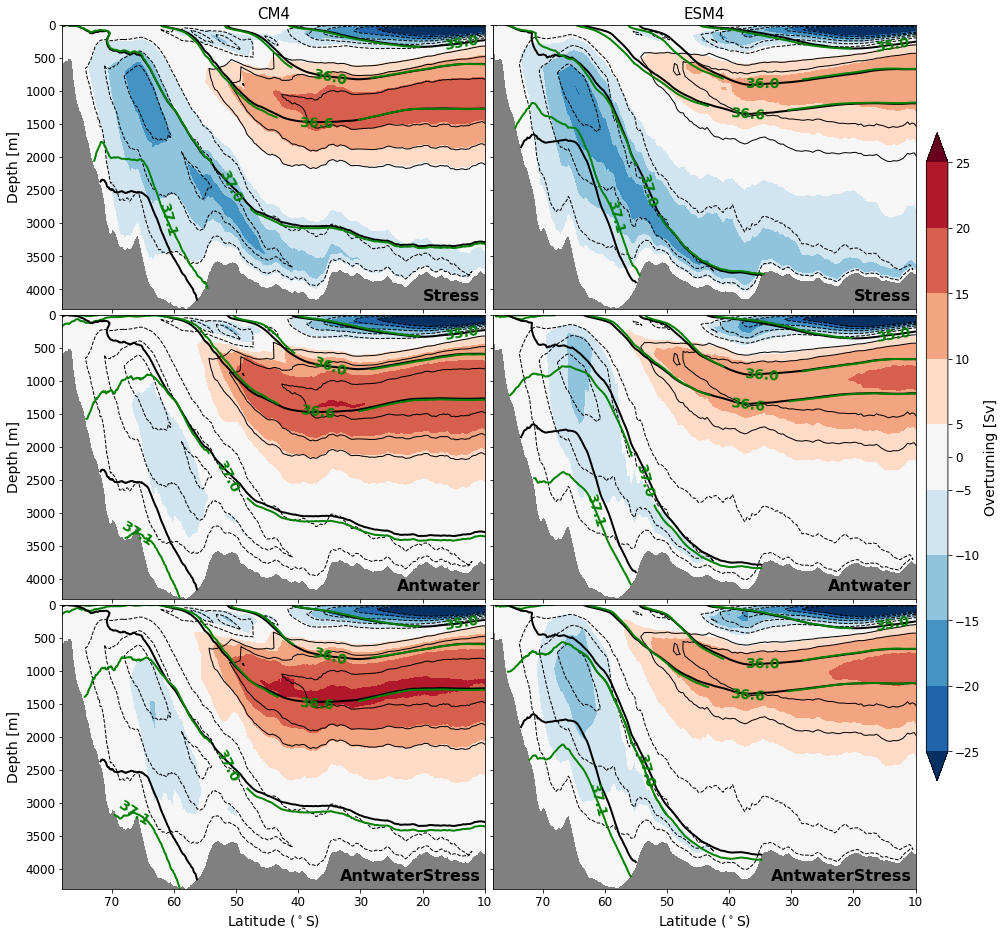

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.02, wspace=0.02)

for i, mod in enumerate(ddict):
    
    for j, exp in enumerate(list(ddict[mod].keys())[1:]):
        
        smoc = []
        depths = []
        sigs = []
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            smoc_m = ddict[mod][exp][mem]['psiz'].reset_coords(drop=True)
            smoc_m['mem'] = int(mem)
            smoc.append(smoc_m)
            
            depth_m = ddict[mod][exp][mem]['psiz'].depth.reset_coords(drop=True)
            depth_m['mem'] = int(mem)
            depths.append(depth_m)
            
            sig_m = ddict[mod][exp][mem]['sig2'].reset_coords(drop=True)
            sig_m['mem'] = int(mem)
            sigs.append(sig_m)
            
        psiz = xr.concat(smoc, dim='mem').mean('mem')
        depth = xr.concat(depths, dim='mem').mean('mem')
        psiz.coords['depth'] = depth
        
        sig = xr.concat(sigs, dim='mem').mean('mem')
        p = psiz.plot.contourf(ax=axs[j,i],x='yq', y='depth', yincrease=False,vmin=-25,vmax=25, 
                               levels=contours,#levels=51
                               cmap='RdBu_r',add_colorbar=False, add_labels=False)
        
        # Contour (Experiment)
        #psiz.plot.contour(ax=axs[j,i],x='yq', y='depth', yincrease=False, levels=contours, 
        #                  colors='k', linewidths=1, add_labels=False)
        # Contour (Control)
        ddict[mod]['control']['psiz'].plot.contour(ax=axs[j,i],x='yq', y='depth', yincrease=False, levels=contours, 
                                                   colors='k', linewidths=1, add_labels=False)
        
        ddict[mod]['control']['sig2'].plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='k',
                                                   linewidths=2, levels=[35.0, 36.0,36.6], add_labels=False)
        
        cs = sig.plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',
                              linewidths=2, levels=[35.0, 36.0, 36.6], add_labels=False)
        clab = axs[j,i].clabel(cs, cs.levels, inline=True, fmt='%1.1f', fontsize=14,
                               manual=[(-14,200), (-35,800), (-37,1500)],inline_spacing=1)
        [txt.set_fontweight('bold') for txt in clab]
        
        if mod=='CM4':
            # Control
            ddict[mod]['control']['sig2'].plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='k',
                                                       linewidths=2,levels=[37.0], add_labels=False)
            ddict[mod]['control']['sig2'].sel(yq=slice(-72,-56.2))\
            .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='k',linewidths=2,
                          levels=[37.1], add_labels=False)
            
            if exp=='antwater':
                cs1 = sig.sel(yq=slice(-74.3,None))\
                        .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                      levels=[37.0], add_labels=False)
                cs2 = sig.sel(yq=slice(-68,-56.5))\
                        .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                      levels=[37.1], add_labels=False)
                
            elif exp=='stress':
                cs1 = sig.plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                       levels=[37.0], add_labels=False)
                cs2 = sig.sel(yq=slice(-73,-54.5),lev=slice(700,None))\
                        .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                      levels=[37.1], add_labels=False)
            else:
                cs1 = sig.sel(yq=slice(-74.6,None))\
                    .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                              levels=[37.0], add_labels=False)
                cs2 = sig.sel(yq=slice(-69.7,-56.8))\
                    .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                  levels=[37.1], add_labels=False)
                
        else:
            # Control
            ddict[mod]['control']['sig2'].sel(yq=slice(None,-34.5))\
                    .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='k',linewidths=2,
                                  levels=[37.0], add_labels=False)
            ddict[mod]['control']['sig2'].sel(yq=slice(-73.7,-54.8))\
                    .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='k',linewidths=2,
                                  levels=[37.1], add_labels=False)
            
            if exp=='antwater':
                cs1 = sig.sel(yq=slice(-75.5,-34.6),lev=slice(700,None))\
                        .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                      levels=[37.0], add_labels=False)
                cs2 = sig.sel(yq=slice(-71.6,-55.5))\
                        .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                      levels=[37.1], add_labels=False)
            elif exp=='stress':
                cs1 = sig.sel(yq=slice(-75.5,-34.2))\
                        .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                      levels=[37.0], add_labels=False)
                cs2 = sig.sel(yq=slice(-74.6,-54.2),lev=slice(700,None))\
                        .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                      levels=[37.1], add_labels=False)
            else:
                cs1 = sig.sel(yq=slice(-73.9,-34.6))\
                        .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                      levels=[37.0], add_labels=False)
                sig.sel(yq=slice(-75.9,-50),lev=slice(700,None))\
                        .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                      levels=[37.0], add_labels=False)
                cs2 = sig.sel(yq=slice(-72.4,-55.5))\
                        .plot.contour(ax=axs[j,i], x='yq', y='lev',yincrease=False,colors='g',linewidths=2,
                                      levels=[37.1], add_labels=False)
                
        clab1 = axs[j,i].clabel(cs1, cs1.levels, inline=True, fmt='%1.1f', fontsize=14,
                                manual=[(-53,2500)],inline_spacing=1)
        [txt.set_fontweight('bold') for txt in clab1]
        clab2 = axs[j,i].clabel(cs2, cs2.levels, inline=False, fmt='%1.1f', fontsize=14, manual=[(-65,3000)])
        [txt.set_fontweight('bold') for txt in clab2]
        
        
        axs[j,i].set_xlim((-78,-10))
        axs[j,i].set_ylim((4300,0))
        axs[j,i].set_xticks(np.arange(-70,0,10))
        axs[j,i].set_xticklabels(np.arange(70,0,-10))
        axs[j,i].tick_params(axis='both', which='both', labelsize=12)
        axs[j,i].set_facecolor('gray')
        
        axs[j,i].text(0.99, 0.02, exp[:8].capitalize()+exp[8:].capitalize() \
                      if exp=='antwaterstress' else exp.capitalize(), ha='right', va='bottom', fontsize=16, 
                      fontweight='bold',transform=axs[j,i].transAxes)
        
        if mod != 'CM4':
            axs[j,i].set_yticklabels([])
        else:
            axs[j,i].set_ylabel('Depth [m]',fontsize=14)
            
        if exp == 'antwaterstress':
            axs[j,i].set_xlabel('Latitude ($^\circ$S)',fontsize=14)
        else:
            axs[j,i].set_xticklabels([])
            
cax = fig.add_axes([0.9, 0.2, 0.02, 0.60])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-25,30,5), orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(r'Overturning [Sv]', fontsize=14)
cb.ax.tick_params(labelsize=12)

axs[0,0].set_title('CM4',fontsize=15)
axs[0,1].set_title('ESM4',fontsize=15)

plt.savefig('smoc_faf_repr.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)

plt.show()

**Figure 5**: Isopycnal overturning reprojected to depth space for CM4 (left) and ESM4 (right). Colors represent the streamfunction of the 20-year mean in Stress (top), Antwater, (middle) and AntwaterStress (bottom), while the thin black contours denote the mean streamfunction of the 100-year period of the Control. Both filled and line contours are plotted with intervals of 5 Sv. The green contours denote the $\sigma_2$ isopycnals in the 20-year mean of the perturbation run, while the thicker solid black contours denote the $\sigma_2$ isopycnals in the 100-year mean Control period.